### Загрузка датасета COCO и кода COCO API
Необходимо раскомментировать код ниже. В нём происходит скачивание и распаковка датасета COCO.
Кроме того, здесь клонируется репозиторий с кодом COCO API (код для работы с данными из COCO)

Запускать лучше всего в Google Cloab или на другой Linux-машине

In [1]:
# !mkdir -p data

# !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
# !cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make

### Импорт необходимых библиотек

In [2]:
import skimage.io as io
import numpy as np

import random
import imageio

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


TensorFlow version: 2.1.0


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [3]:
COCO_ROOT = 'F://train2017//'
import sys
import os
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [4]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):
        print(x.shape)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = ASPPNet()


### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')
BATCH_SIZE = 20
EPOCHS = 5
INP_SIZE = 256
train_ds = COCO_dataset_train.train_dataset(batch_size = BATCH_SIZE, epochs = EPOCHS, inp_size = INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size = BATCH_SIZE, inp_size = INP_SIZE)

loading annotations into memory...
Done (t=17.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


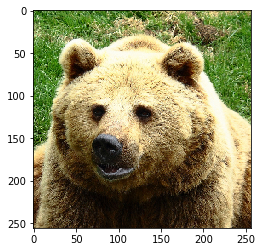

(None, 256, 256, 3)


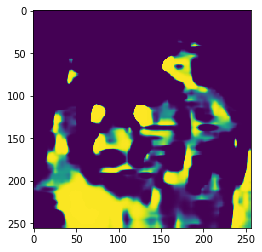

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
def pred(img):
  out = model.predict(image.img_to_array(img)[None, ...])
#   seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
#   seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
  plt.imshow(image.array_to_img(out[0,...]))
  plt.show()
img = image.load_img(COCO_ROOT+"val2017//000000000285.jpg",target_size=(256, 256))

plt.imshow(img)
plt.show()
pred(img)



In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(loss=loss, metrics=['accuracy'], optimizer='adam')
# model.build(input_shape=(20,256,256,3))
# model.load_weights('good_weights2.h5')

Train for 40 steps
Epoch 1/5
(20, 256, 256, None)
(20, 256, 256, None)
40/40 [==============================] - 1060s 27s/step - loss: 0.3729 - accuracy: 0.8232
Epoch 2/5
40/40 [==============================] - 1052s 26s/step - loss: 0.3435 - accuracy: 0.8371
Epoch 3/5
40/40 [==============================] - 1058s 26s/step - loss: 0.3536 - accuracy: 0.8310
Epoch 4/5
40/40 [==============================] - 1053s 26s/step - loss: 0.3539 - accuracy: 0.8329
Epoch 5/5
40/40 [==============================] - 1049s 26s/step - loss: 0.3290 - accuracy: 0.8443


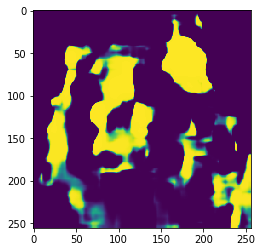

Train for 40 steps
Epoch 1/5
40/40 [==============================] - 1053s 26s/step - loss: 0.3381 - accuracy: 0.8408
Epoch 2/5
40/40 [==============================] - 1067s 27s/step - loss: 0.3476 - accuracy: 0.8333
Epoch 3/5
40/40 [==============================] - 1084s 27s/step - loss: 0.3457 - accuracy: 0.8405
Epoch 4/5
40/40 [==============================] - 1062s 27s/step - loss: 0.3551 - accuracy: 0.8272
Epoch 5/5
40/40 [==============================] - 1055s 26s/step - loss: 0.3492 - accuracy: 0.8423


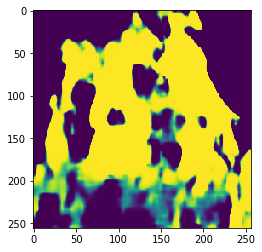

Train for 40 steps
Epoch 1/5
40/40 [==============================] - 1057s 26s/step - loss: 0.3545 - accuracy: 0.8354
Epoch 2/5
40/40 [==============================] - 1057s 26s/step - loss: 0.3487 - accuracy: 0.8385
Epoch 3/5
40/40 [==============================] - 1062s 27s/step - loss: 0.3208 - accuracy: 0.8522
Epoch 4/5
40/40 [==============================] - 1067s 27s/step - loss: 0.3098 - accuracy: 0.8594
Epoch 5/5
40/40 [==============================] - 1097s 27s/step - loss: 0.3284 - accuracy: 0.8480


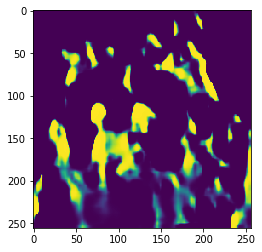

Train for 40 steps
Epoch 1/5
40/40 [==============================] - 1078s 27s/step - loss: 0.3321 - accuracy: 0.8451
Epoch 2/5
40/40 [==============================] - 1088s 27s/step - loss: 0.3281 - accuracy: 0.8477
Epoch 3/5
40/40 [==============================] - 1077s 27s/step - loss: 0.3325 - accuracy: 0.8474
Epoch 4/5
40/40 [==============================] - 1063s 27s/step - loss: 0.3484 - accuracy: 0.8339
Epoch 5/5
40/40 [==============================] - 1059s 26s/step - loss: 0.3330 - accuracy: 0.8446


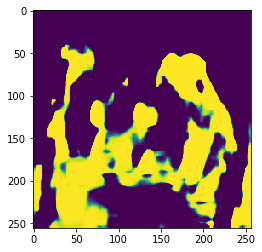

In [12]:
for i in range(4):
  hist = model.fit(train_ds,epochs=5,steps_per_epoch=40)
  pred(img)

In [21]:
model.evaluate(val_ds)

(20, None, None, None)
134/134 [==============================] - 421s 3s/step - loss: 0.3548 - accuracy: 0.8277


[0.3548043721647405, 0.8277303]

In [14]:
# model.save_weights('good_weights2.h5')

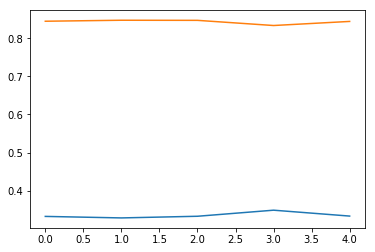

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])
plt.show()

pred


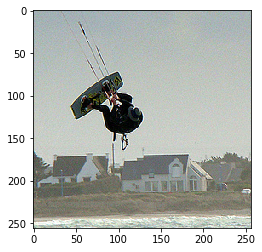

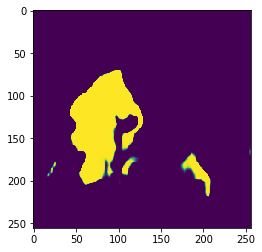

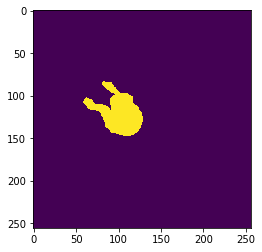

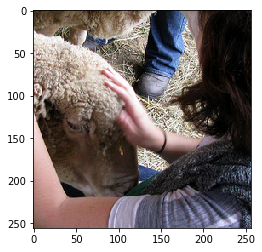

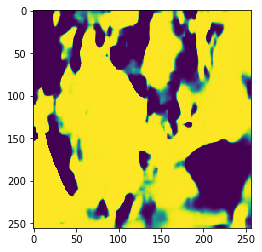

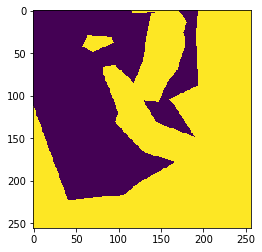

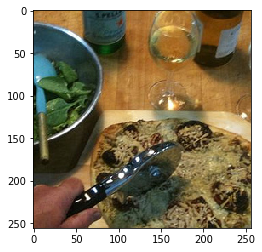

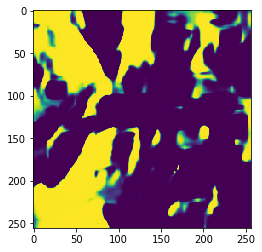

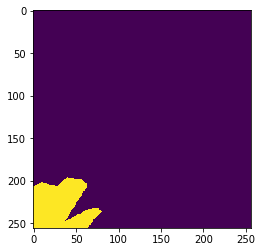

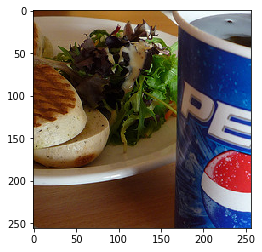

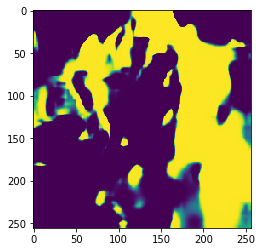

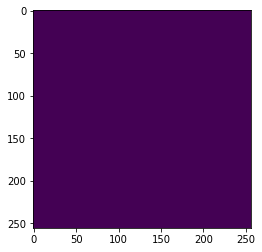

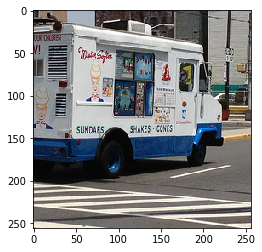

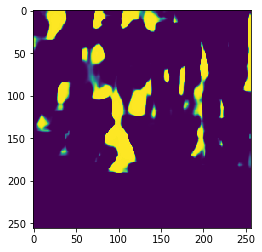

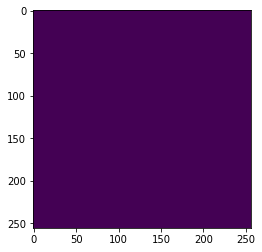

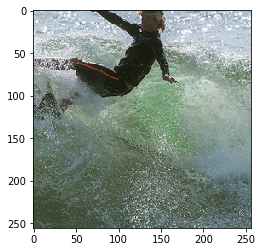

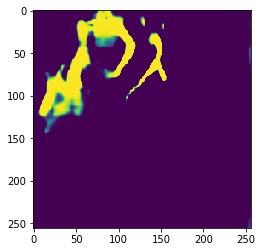

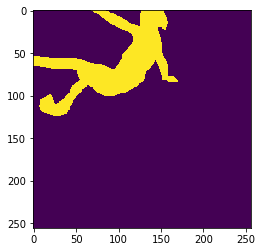

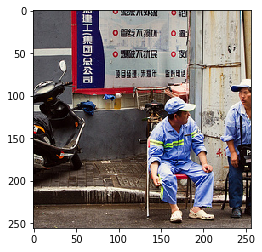

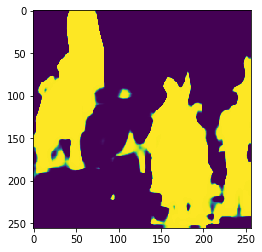

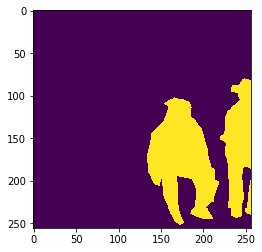

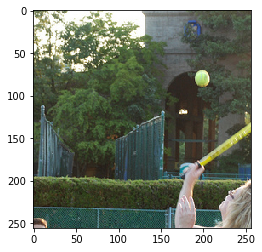

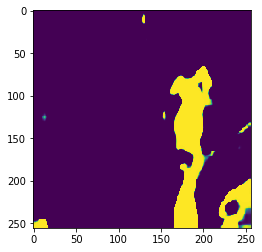

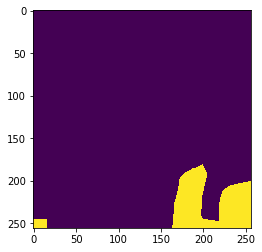

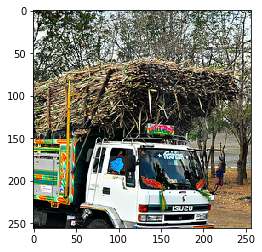

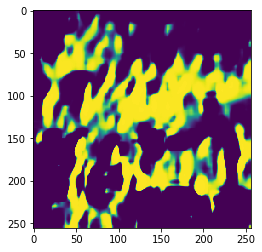

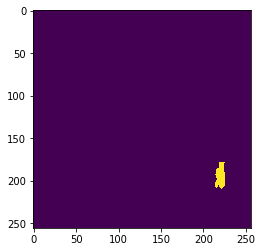

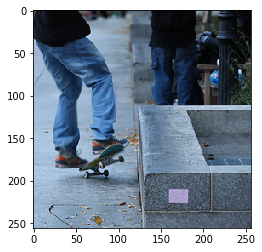

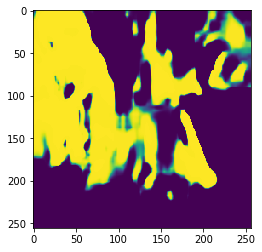

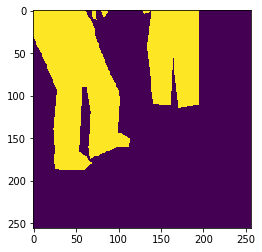

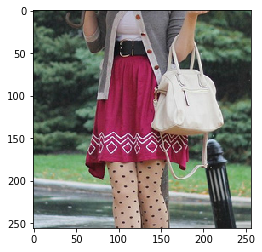

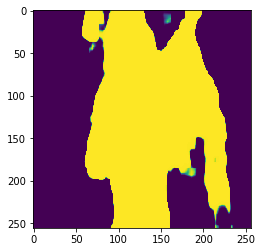

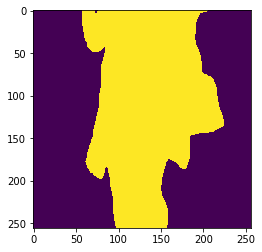

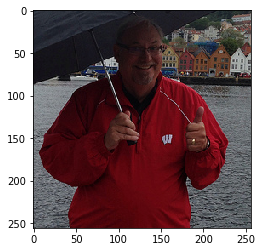

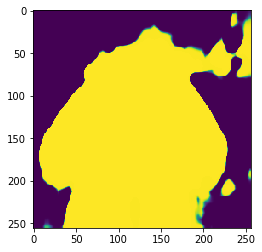

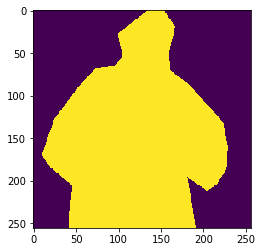

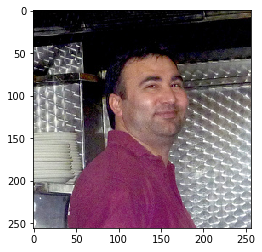

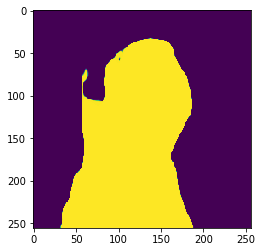

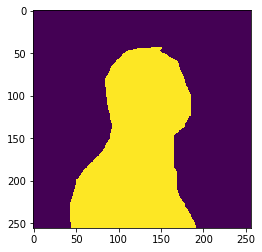

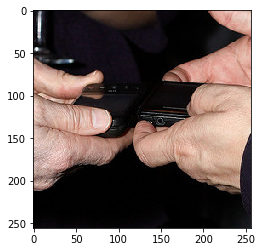

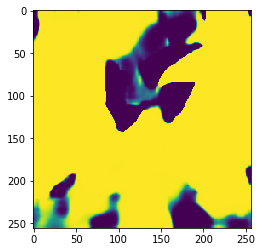

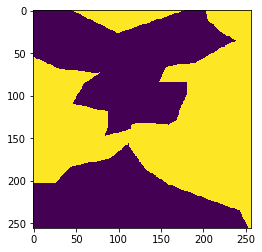

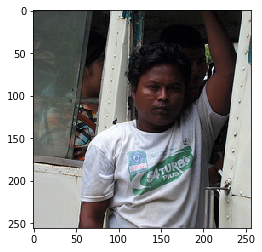

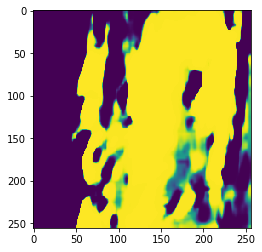

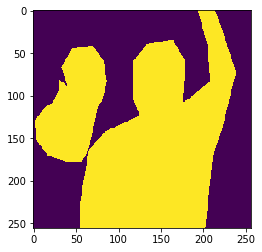

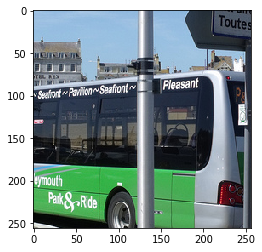

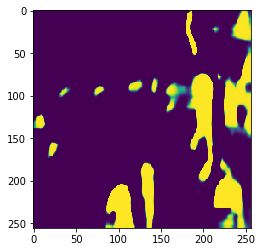

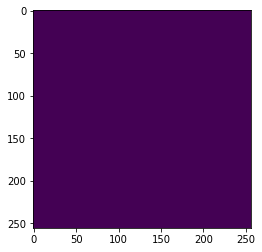

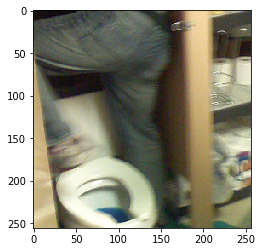

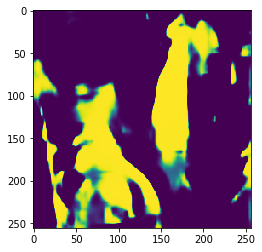

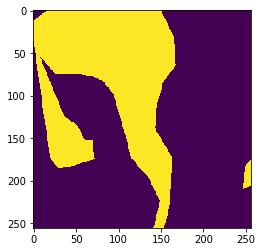

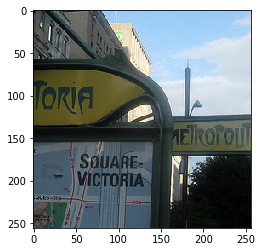

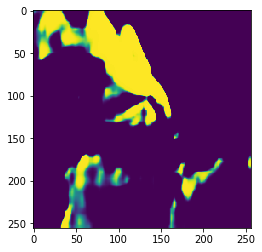

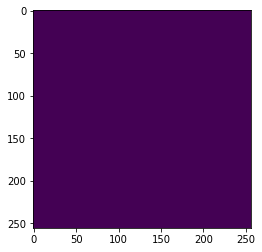

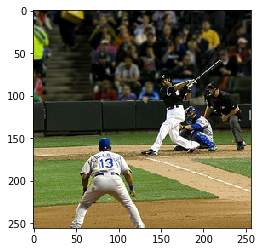

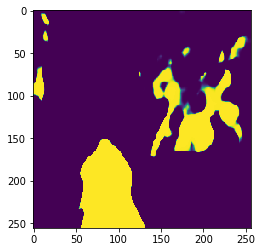

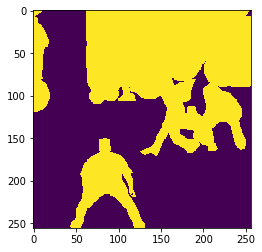

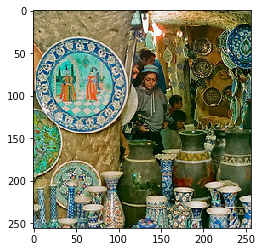

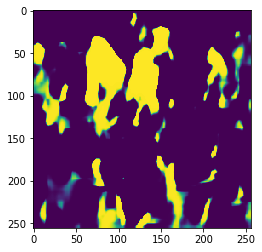

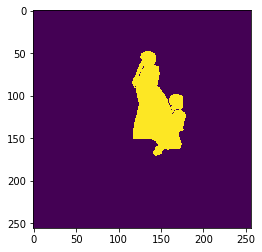

pred


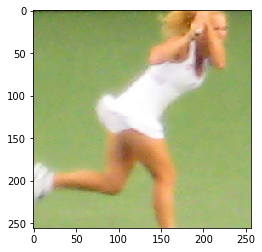

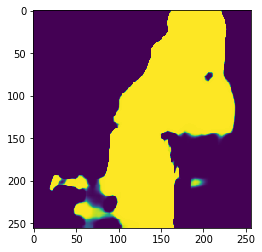

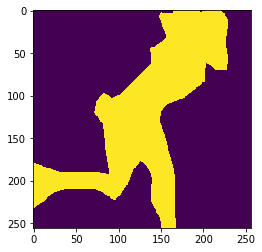

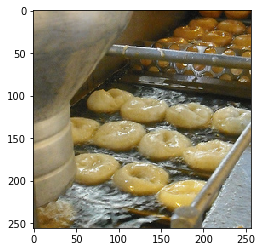

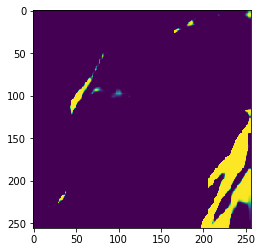

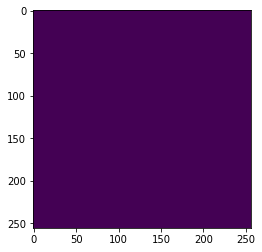

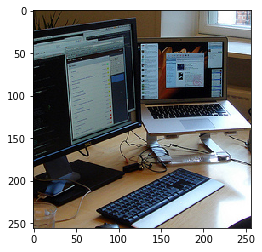

KeyboardInterrupt: 

In [20]:
for sample in val_ds:
    print('pred')
    count = -1
    for imgs in sample[:][0]:
        count+=1
        img = image.array_to_img(image.img_to_array(imgs))
        plt.imshow(img)
        plt.show()    
        
        pred(img)

        real = sample[:][1][count]
        plt.imshow(image.array_to_img(real))
        plt.show()    
        